In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from enum import Enum, unique
@unique
class Logic(Enum):
    OR = 0
    AND = 1

In [3]:
class MFInput:
    def __init__(self, name, xs, ys):
        self.name = name
        self.points = np.array(list(zip(xs, ys)))
        self.size = xs.size
        self.x0 = None
        self.mi = None
    
    def setMi(self, x0):
        self.x0 = x0
        self.mi = self.getMi()
        
    def getY(self, x1, y1, x2, y2):
        if y1 == y2:
            return y1
        if y1 < y2:
            return (self.x0 - x1) / (x2 -x1)
        return (x2 - self.x0) / (x2 - x1)
        
    def getMi(self):
        if self.x0 < self.points[0][0]: 
            return self.points[0][1]
        if self.x0 > self.points[-1][0]:
            return self.points[-1][1]
        for i in range(1, self.points.size):
            x1 = self.points[i - 1][0]
            x2 = self.points[i][0]
            if self.x0 >= x1 and self.x0 < x2:
                y1 = self.points[i - 1][1]
                y2 = self.points[i][1]
                return self.getY(x1, y1, x2, y2)
        return None
        
    def __str__(self):
        out = '['
        for (x, y) in self.points:
            out = out + '(' + str(x) + ',' + str(y) + '), '
        out = out[:-2] + ']'
        return out
    
    def show_diagram(self):
        xs = [p[0] for p in self.points]
        ys = [p[1] for p in self.points]
        
        plt.ylim(-0.1, 1.4)
        plt.xlabel('input value')
        plt.ylabel(self.name + ' value')
        plt.title('Fuzzy Diagram')
        plt.plot(xs, ys, 'k')
        
        plt.plot([self.x0, self.x0], [0, self.mi], 'ro--')

In [4]:
test = MFInput("fuzzy", np.array([1, 5, 9, 15, 20]), np.array([1, 0, 0, 1, 0]))
test.setMi(14)

In [5]:
print(test)

[(1,1), (5,0), (9,0), (15,1), (20,0)]


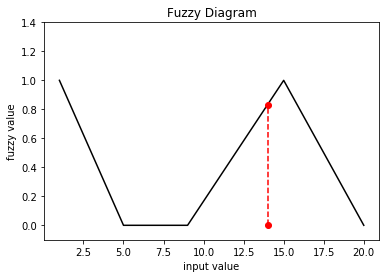

In [6]:
test.show_diagram()

In [7]:
class MFOutput:
    def __init__(self, name, xs, ys):
        self.name = name
        self.points = np.array(list(zip(xs, ys)))
        self.size = xs.size
        
        self.center = None
        sum1 = 0
        cnt1 = 0
        for i in range(0, self.size):
            if ys[i] == 1:
                sum1 = sum1 + xs[i]
                cnt1 = cnt1 + 1
        self.center = sum1/cnt1
        self.mi = 0
        
    def show_diagram(self, solution):
        xs = [p[0] for p in self.points]
        ys = [p[1] for p in self.points]
        
        plt.ylim(-0.1, 1.4)
        plt.xlabel('output')
        plt.ylabel(self.name + ' value')
        plt.title('Fuzzy Diagram')
        plt.plot(xs, ys, 'k')
        
        plt.plot([solution, solution], [0, 1], 'ro--')

In [8]:
class Rule:
    def __init__(self, inputs, output, operator = Logic.AND):
        self.inputs = inputs
        self.output = output
        self.operator = operator
    
    def apply_rule(self):
        n = self.inputs.size
        if self.operator == Logic.OR:
            mi = 0
            for i in range(0, n):
                mi = max(mi, self.inputs[i].mi)
        else:
            mi = 1
            for i in range(0, n):
                mi = min(mi, self.inputs[i].mi)
                
        self.output.mi = max(self.output.mi, mi)
        
    def __str__(self):
        n = self.inputs.size
        out = ''
        for i in range(0, n-1):
            out = out + self.inputs[i].name + ' ' + str(self.operator) + ' '
        out = out + self.inputs[n-1].name
        return out

In [9]:
class FuzzyInput:
    def __init__(self, name, inputs):
        self.name = name
        self.inputs = inputs
        self.size = self.inputs.size
    
    def __getitem__(self, index):
         return self.inputs[index]
        
    def __str__(self):
        return self.name + " : " + str(self.inputs)
    
    def show_diagram(self):
        for i in range(0, self.size):
            self.inputs[i].show_diagram()
        plt.ylabel(self.name)
        plt.show()

In [10]:
class FuzzyOutput:
    def __init__(self, name, outputs):
        self.name = name
        self.outputs = outputs
        self.size = self.outputs.size
    
    def __getitem__(self, index):
         return self.outputs[index]
        
    def __str__(self):
        return self.name + " : " + str(self.outputs)
    
    def show_diagram(self, solution):
        for i in range(0, self.size):
            self.outputs[i].show_diagram(solution)
        plt.ylabel(self.name)
        plt.show()

In [11]:
class FuzzyRules:
    def __init__(self, rules):
        self.rules = rules
        self.size = self.rules.size
        self.size = self.rules.size
    
    def __getitem__(self, index):
         return self.rules[index]
        
    def __str__(self):
        out = ''
        for i in range(0, self.size):
            out = out + str(self.rules[i]) + '\n'
        return out

In [12]:
class FuzzySystem:
    def __init__(self, inputs, output, rules):
        self.inputs = inputs
        self.output = output
        self.rules = rules
        self.solution = None
        
    def fit(self, x0s):
        for i in range(0, self.inputs.size):
            x0 = x0s[i]
            for j in range(0, self.inputs[i].size):
                self.inputs[i][j].setMi(x0)
            
        for i in range(0, self.rules.size):
            self.rules[i].apply_rule()
            
        numerator = 0
        denominator = 0 
        for mfo in self.output:
            numerator += mfo.mi * mfo.center
            denominator += mfo.mi
        self.solution = numerator/denominator
        
    def inputs_info(self):
        if self.solution == None:
            return
        for i in range(0, self.inputs.size):
            self.inputs[i].show_diagram()
            
    def output_info(self):
        if self.solution == None:
            return
        self.output.show_diagram(self.solution)
        
    def full_info(self):
        self.inputs_info()
        self.output_info()

In [13]:
input11 = MFInput("mala", np.array([3, 10]), np.array([1, 0]))
input12 = MFInput("srednja", np.array([7, 10, 12, 15]), np.array([0, 1, 1, 0]))
input13 = MFInput("velika", np.array([12, 15]), np.array([0, 1]))
potrosnja = FuzzyInput("potrosnja", np.array([input11, input12, input13]))

input21 = MFInput("visoka", np.array([5, 10]), np.array([1, 0]))
input22 = MFInput("niska", np.array([8, 15]), np.array([0, 1]))
pouzdanost = FuzzyInput("pouzdanost", np.array([input21, input22]))

output11 = MFOutput("mala", np.array([7, 15]), np.array([1, 0]))
output12 = MFOutput("srednja", np.array([7, 15, 25, 40]), np.array([0, 1, 1, 0]))
output13 = MFOutput("velika", np.array([25, 40]), np.array([0, 1]))
vrednost = FuzzyOutput("vrednost", np.array([output11, output12, output13]))

pravila = FuzzyRules(np.array([
    Rule(np.array([potrosnja[0], pouzdanost[0]]), vrednost[2], Logic.AND),
    Rule(np.array([potrosnja[0], pouzdanost[1]]), vrednost[1], Logic.AND),
    Rule(np.array([potrosnja[1], pouzdanost[0]]), vrednost[1], Logic.AND),
    Rule(np.array([potrosnja[1], pouzdanost[1]]), vrednost[1], Logic.AND),
    Rule(np.array([potrosnja[2], pouzdanost[0]]), vrednost[1], Logic.AND),
    Rule(np.array([potrosnja[2], pouzdanost[1]]), vrednost[0], Logic.AND)
]))

fs = FuzzySystem(np.array([potrosnja, pouzdanost]), vrednost, pravila)
fs.fit(np.array([9, 8]))
print(fs.solution)

25.26315789473684


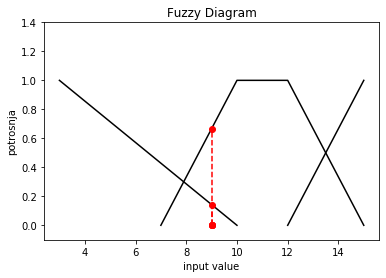

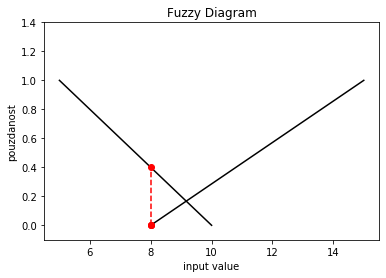

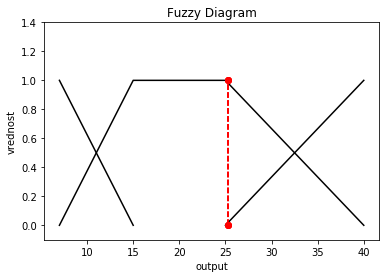

In [14]:
fs.full_info()